# Modelling using XGB Regressor

## Import libraries

In [699]:
import pandas as pd, numpy as np, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV

# Librerías para plots
from sklearn import tree
#import graphviz
from scipy.stats import norm
from scipy.stats import t
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import shap
from sklearn.metrics import fbeta_score, make_scorer
%matplotlib inline

## Read file and prepare data 

In [647]:
#df = pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed.csv')
#df = pd.read_csv('/Users/lucas_botella/Downloads/cluster_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/cluster_per_deaths_for_model.csv')
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL.csv')
del df['Unnamed: 0']
del df['R0']
del df['Excess mortality P-scores, all ages Prev 7 days']
del df['Excess mortality P-scores, all ages Prev 36 days']
del df['deaths_prev_7']
del df['deaths_prev_36']
del df['average_deaths_2015_2019_all_ages']
del df['month']
del df['life_expectancy']
del df['UN Population Division (Median Age) (2017)']

del df['Excess mortality P-scores, all ages Prev 18 days']
del df['Excess mortality P-scores, all ages']

df=df[[c for c in df if c not in ['deaths']] 
       + ['deaths']]

In [648]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'doctors_per_1000', 'nurses_per_1000', 'beds_per_1000',
       'number_of_arrivals', 'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', '%df_population_gr_65', 'deaths_prev_18',
       'accumulated', 'deaths'],
      dtype='object')

In [649]:
date1=pd.Timestamp(2020, 3, 1)
df['mobility']=(df['retail_and_recreation']*0.6+df['transit_stations']*0.3+df['grocery_and_pharmacy']*0.2)
del df['retail_and_recreation']
del df['grocery_and_pharmacy']
del df['residential']
del df['transit_stations']
del df['workplaces']
del df['parks']
#df['days_from_beginning']=(pd.to_datetime(df['Date'])-date1).dt.days

df['tourism']=df['number_of_arrivals']/df['international_travel_controls']
df['awareness'] = df['public_information_campaigns']*0.2+df['facial_coverings']*0.8
df['work_life_closures']=df['workplace_closures']*0.7+df['school_closures']*0.3
df['government_support']=df['debt_relief']*0.5+df['income_support']*0.5
df['%df_population_gr_65']=df['%df_population_gr_65']-(df['accumulated']*df['%df_population_gr_65']/100)
df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['deaths_prev_18'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['deaths_prev_18']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['deaths_prev_18'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['deaths_prev_18']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['deaths_prev_18'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['deaths_prev_18']), axis=1)
df['hospital_availability']=df['nurses_per_1000']*0.2+df['doctors_per_1000']*0.2+df['beds_per_1000']*0.6
df['youth_effect']=df['%youth_unemployment_total']*df['mobility']

del df['contact_tracing']
del df['testing_policy']
del df['international_travel_controls']
del df['number_of_arrivals']
del df['public_information_campaigns']
del df['facial_coverings']
del df['workplace_closures']
del df['school_closures']
del df['debt_relief']
del df['income_support']
del df['doctors_per_1000']
del df['beds_per_1000']
del df['nurses_per_1000']
del df['%youth_unemployment_total']


df=df[[c for c in df if c not in ['deaths']] 
       + ['deaths']]

In [650]:
df.columns

Index(['Code', 'Date', 'restrictions_internal_movements',
       'close_public_transport', 'stay_home_requirements',
       'restriction_gatherings', 'cancel_public_events', 'Holiday', 'temp',
       'prcp', 'urban_population', 'total_vaccinations_per_100',
       '%df_population_gr_65', 'deaths_prev_18', 'accumulated', 'mobility',
       'tracing', 'tourism', 'awareness', 'work_life_closures',
       'government_support', 'hospital_availability', 'youth_effect',
       'deaths'],
      dtype='object')

df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df

In [651]:
df

,Code,Date,restrictions_internal_movements,close_public_transport,stay_home_requirements,restriction_gatherings,cancel_public_events,Holiday,temp,prcp,...,accumulated,mobility,tracing,tourism,awareness,work_life_closures,government_support,hospital_availability,youth_effect,deaths
0,AUS,2020-03-08,0.0,0.0,0.0,0.000000,0.000000,0.0,23.571259,0.106900,...,0.000762,2.467767,2.0,2.754333e+06,0.4,0.0,0.0,-1045.195835,29.218358,145.995875
1,AUS,2020-03-15,0.0,0.0,0.0,0.000000,0.000000,0.0,22.446137,0.134501,...,0.001320,3.068243,2.0,2.754333e+06,0.4,0.0,0.0,-764.686802,36.327996,144.432750
2,AUS,2020-03-22,0.0,0.0,0.0,0.000000,0.000000,0.0,21.810602,0.160434,...,0.001926,4.248971,2.0,2.754333e+06,0.4,0.0,0.0,-830.988937,50.307822,227.591000
3,AUS,2020-03-29,0.0,0.0,0.0,0.000000,0.000000,0.0,21.346512,0.142010,...,0.002502,3.859229,2.0,2.754333e+06,0.4,0.0,0.0,-788.487568,45.693267,379.214125
4,AUS,2020-04-05,0.0,0.0,0.0,0.857143,0.571429,0.0,21.176835,0.054789,...,0.002969,2.175471,2.0,2.754333e+06,0.4,0.0,0.5,-638.918505,25.757582,290.073225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,2.0,1.0,2.0,4.000000,2.000000,0.0,2.886531,0.052132,...,0.179232,-22.240829,1.0,2.520267e+07,4.4,2.3,1.5,-141557.856784,-184.598881,27279.312225
2038,USA,2021-01-17,2.0,1.0,2.0,4.000000,2.000000,1.0,1.707192,0.066843,...,0.188522,-26.124486,1.0,2.520267e+07,4.4,2.3,1.5,-140940.129604,-216.833236,25178.047837
2039,USA,2021-01-24,2.0,1.0,2.0,4.000000,2.000000,1.0,2.500769,0.094533,...,0.198645,-28.453057,1.0,2.520267e+07,4.4,2.3,1.5,-153569.218621,-236.160380,21925.914262
2040,USA,2021-01-31,2.0,1.0,2.0,4.000000,2.000000,0.0,1.198128,0.038337,...,0.206956,-28.536829,1.0,2.520267e+07,4.4,2.3,1.5,-126080.359104,-236.855683,18213.433013


## PCA

In [256]:
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)
df['accumulated'] = df['accumulated'].fillna(0)
df['urban_population'] = df['urban_population'].fillna(df['urban_population'].mean())
df['parks'] = df['parks'].fillna(df['parks'].mean())
df['temp'] = df['temp'].fillna(df['temp'].mean())
df['prcp'] = df['prcp'].fillna(df['prcp'].mean())
df['%youth_unemployment_total'] = df['%youth_unemployment_total'].fillna(df['%youth_unemployment_total'].mean())
df['%df_population_gr_65'] = df['%df_population_gr_65'].fillna(df['%df_population_gr_65'].mean())
df['doctors_per_1000'] = df['doctors_per_1000'].fillna(df['doctors_per_1000'].mean())
df['nurses_per_1000'] = df['nurses_per_1000'].fillna(df['nurses_per_1000'].mean())
df['beds_per_1000'] = df['beds_per_1000'].fillna(df['beds_per_1000'].mean())

In [257]:
df.isna().sum()

Code                               0
Date                               0
retail_and_recreation              0
grocery_and_pharmacy               0
residential                        0
transit_stations                   0
parks                              0
workplaces                         0
contact_tracing                    0
testing_policy                     0
international_travel_controls      0
restrictions_internal_movements    0
close_public_transport             0
public_information_campaigns       0
facial_coverings                   0
stay_home_requirements             0
restriction_gatherings             0
cancel_public_events               0
workplace_closures                 0
school_closures                    0
debt_relief                        0
income_support                     0
Holiday                            0
temp                               0
prcp                               0
doctors_per_1000                   0
nurses_per_1000                    0
b

In [258]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'doctors_per_1000', 'nurses_per_1000', 'beds_per_1000',
       'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', '%df_population_gr_65', 'deaths_prev_18',
       'accumulated', 'deaths'],
      dtype='object')

In [259]:
features=['retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'doctors_per_1000', 'nurses_per_1000', 'beds_per_1000',
       'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', '%df_population_gr_65', 'deaths_prev_18',
       'accumulated']

# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['deaths']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

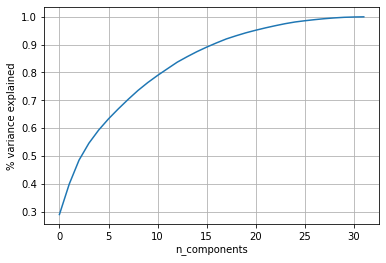

In [260]:
from sklearn.decomposition import PCA
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [262]:
pca = PCA(n_components = 15)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
principalDf['Date']=df['Date']
principalDf['deaths']=df['deaths']
df=principalDf
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Date,deaths
0,-5.383485,0.735357,1.406325,-1.047541,-1.126109,1.931080,1.106623,-0.987422,-0.345567,-0.727187,0.217910,0.821810,0.831588,0.860347,0.037062,2020-03-08,145.995875
1,-5.495682,0.738772,1.361655,-1.033981,-0.956287,1.988177,1.188331,-1.117522,-0.315995,-0.655928,0.417178,0.818546,0.788669,0.851811,-0.095565,2020-03-15,144.432750
2,-5.560257,0.776475,1.302328,-1.016410,-0.843421,2.018832,1.255388,-1.229097,-0.256050,-0.568439,0.615102,0.788711,0.755773,0.854733,-0.188559,2020-03-22,227.591000
3,-5.512249,0.765263,1.307785,-0.930932,-0.886232,1.990138,1.163911,-1.055881,-0.257131,-0.657791,0.512510,0.843160,0.750142,0.846887,-0.182080,2020-03-29,379.214125
4,-4.944721,0.549156,0.706699,-0.336912,-1.135472,1.870396,0.613316,-0.292458,-0.244261,-1.094927,0.160508,0.588273,0.716205,0.811030,-0.335674,2020-04-05,290.073225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,7.340356,17.488150,-1.459383,2.242913,-1.672876,-0.011699,0.107852,-1.354279,-1.260513,0.487610,-1.145516,0.000966,0.227957,-1.079113,-0.838034,2021-01-10,27279.312225
2038,7.835683,17.142420,-1.309305,2.807511,-1.809203,-0.269917,0.086291,-1.564569,-0.058811,1.106494,-1.343979,0.575637,0.609997,-1.049832,-0.730303,2021-01-17,25178.047837
2039,8.510863,18.666685,-1.297304,2.979785,-1.919582,-0.190722,0.293128,-2.017676,-0.222120,1.529241,-1.427779,0.450190,0.839398,-0.998307,-0.684245,2021-01-24,21925.914262
2040,7.183836,15.404264,-1.233095,2.124530,-0.991318,0.336438,-0.081181,-0.821371,-1.315310,0.813305,-1.285020,0.060699,0.529803,-0.875026,-0.790743,2021-01-31,18213.433013


## Apply model and view results 

pip install xgboost

## XGBoost Regressor 

### Train and Test Split

In [652]:
date1=pd.Timestamp(2021, 1, 1)
date_aux=pd.Timestamp(2020, 4, 1)

#df=df[(pd.to_datetime(df['Date']) > date_aux)]
X_1=df[(pd.to_datetime(df['Date']) <= date1)]
X_2=df[(pd.to_datetime(df['Date']) > date1)]
X_train=X_1[X_1.columns[2:-1]]
X_test=X_2[X_2.columns[2:-1]]
y_train=X_1['deaths']
y_test=X_2['deaths']

In [653]:
X_train

,restrictions_internal_movements,close_public_transport,stay_home_requirements,restriction_gatherings,cancel_public_events,Holiday,temp,prcp,urban_population,total_vaccinations_per_100,...,deaths_prev_18,accumulated,mobility,tracing,tourism,awareness,work_life_closures,government_support,hospital_availability,youth_effect
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,23.571259,0.106900,85.904,NaN,...,193.202250,0.000762,2.467767,2.0,2.754333e+06,0.4,0.0,0.0,-1045.195835,29.218358
1,0.0,0.0,0.000000,0.000000,0.000000,0.0,22.446137,0.134501,85.904,NaN,...,141.619125,0.001320,3.068243,2.0,2.754333e+06,0.4,0.0,0.0,-764.686802,36.327996
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,21.810602,0.160434,85.904,NaN,...,153.811500,0.001926,4.248971,2.0,2.754333e+06,0.4,0.0,0.0,-830.988937,50.307822
3,0.0,0.0,0.000000,0.000000,0.000000,0.0,21.346512,0.142010,85.904,NaN,...,145.995875,0.002502,3.859229,2.0,2.754333e+06,0.4,0.0,0.0,-788.487568,45.693267
4,0.0,0.0,0.000000,0.857143,0.571429,0.0,21.176835,0.054789,85.904,NaN,...,118.491450,0.002969,2.175471,2.0,2.754333e+06,0.4,0.0,0.5,-638.918505,25.757582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,2.0,1.0,1.000000,3.000000,2.000000,1.0,11.963407,0.046064,82.058,NaN,...,16564.570380,0.139396,-21.271371,1.0,2.520267e+07,4.4,2.3,1.5,-76556.822296,-176.552387
2032,2.0,1.0,1.428571,3.428571,2.000000,0.0,7.142733,0.074066,82.058,NaN,...,14646.939450,0.143858,-22.940814,1.0,2.520267e+07,4.4,2.6,1.5,-67693.532138,-190.408763
2033,2.0,1.0,2.000000,4.000000,2.000000,0.0,7.163158,0.047543,82.058,NaN,...,16873.860575,0.148999,-22.434700,1.0,2.520267e+07,4.4,3.0,1.5,-77986.361578,-186.208014
2034,2.0,1.0,2.000000,4.000000,2.000000,1.0,4.687591,0.075228,82.058,NaN,...,18091.619975,0.154511,-28.377471,1.0,2.520267e+07,4.4,2.9,1.5,-83614.845524,-235.533018


### GridSearchCV 

In [729]:
import warnings
warnings.filterwarnings('ignore')

In [741]:
#Mape custom scoring function
def mape_fun(pred, train): 
    return np.mean(np.abs((pred - train) / train)) * 100

In [742]:
# A parameter grid for XGBoost
params = {'subsample':[0.8,0.9,1],'max_depth': [3,4,5], 'n_estimators':[12,13,14]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params, verbose=1, n_jobs=-1, scoring=make_scorer(mape_fun))

In [743]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:    2.9s


CPU times: user 580 ms, sys: 23.5 ms, total: 604 ms
Wall time: 3.36 s


[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    3.3s finished


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=

In [744]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=13, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Model evaluation metrics

### Test Set

In [745]:
y_pred=grid.best_estimator_.predict(X_test)

In [746]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape=np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 1045.8202065278178
mse score is 6397069.764342736
rmse score is 2529.242923157587
r2 score is 0.7168030695223111
mape score is inf


### Train Set

In [721]:
y_pred_train=grid.best_estimator_.predict(X_train)

In [747]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape=np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 535.1692710654299
mse score is 1439475.1510787187
rmse score is 1199.7812930191565
r2 score is 0.8381082098821839
mape score is inf


### Test Set Predictions 

In [748]:
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
#df_eval=df_eval.sort_values('Difference')
df_eval

,Actual,Predicted,Difference
47,-278.960990,1.322221,280.283211
48,-11.721050,1.322221,13.043271
49,-5.540860,1.322221,6.863081
89,345.992385,1103.329224,757.336839
90,184.052760,1103.329224,919.276464
...,...,...,...
2037,27279.312225,20921.574219,6357.738006
2038,25178.047837,20097.902344,5080.145494
2039,21925.914262,19821.041016,2104.873247
2040,18213.433013,20097.902344,1884.469331


In [749]:
#mape corrected
df_eval.Difference.sum()/df_eval.Actual.sum()

0.7020351077901644

## Model evaluation plots

Text(0.5, 1.0, 'Difference Histogram')

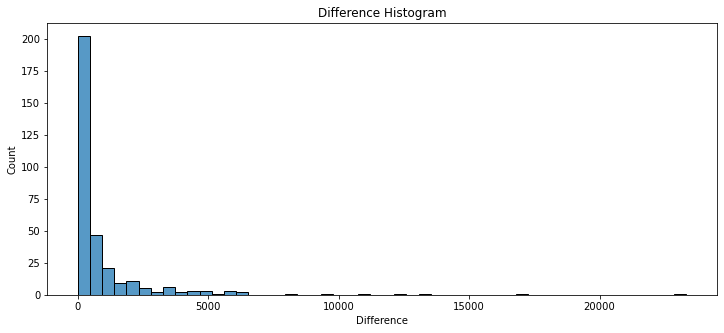

In [750]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

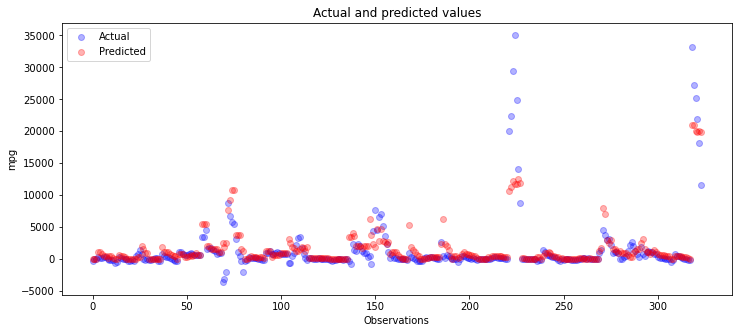

In [751]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

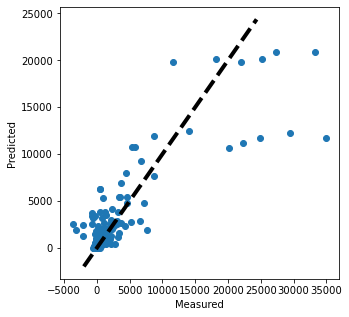

In [752]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

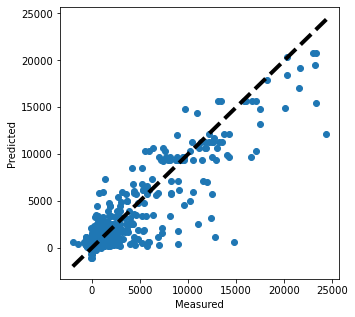

In [753]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

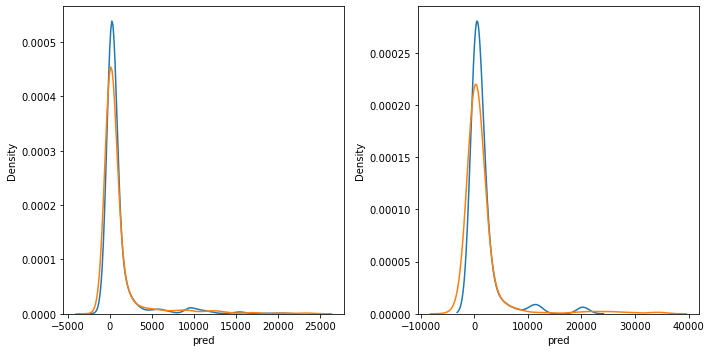

In [754]:
import seaborn as sns
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0])
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1])
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [755]:
res_df_test['dif_abs'].sum()/res_df_test['test'].sum()

0.7020351349002

In [756]:
res_df_test

,pred,test,dif,dif_abs,dif%
47,1.322221,-278.960990,280.28,280.28,-100.47
48,1.322221,-11.721050,13.04,13.04,-111.28
49,1.322221,-5.540860,6.86,6.86,-123.86
89,1103.329224,345.992385,757.34,757.34,218.89
90,1103.329224,184.052760,919.28,919.28,499.46
...,...,...,...,...,...
2037,20921.574219,27279.312225,-6357.74,6357.74,-23.31
2038,20097.902344,25178.047837,-5080.15,5080.15,-20.18
2039,19821.041016,21925.914262,-2104.87,2104.87,-9.60
2040,20097.902344,18213.433013,1884.47,1884.47,10.35


In [761]:
df.iloc[90]

Code                                       AUT
Date                                2021-01-10
restrictions_internal_movements              1
close_public_transport                       1
stay_home_requirements                       2
restriction_gatherings                       4
cancel_public_events                         2
Holiday                                      0
temp                                   1.86147
prcp                                 0.0292185
urban_population                        58.094
total_vaccinations_per_100                 NaN
%df_population_gr_65                   19.0541
deaths_prev_18                          824.44
accumulated                           0.112871
mobility                              -34.4225
tracing                                      2
tourism                            9.37367e+06
awareness                                  3.4
work_life_closures                         1.7
government_support                           2
hospital_avai

In [762]:
res_df_test['dif%'].mean()

inf

In [763]:
df['deaths'].describe()

count     2042.000000
mean      1159.712029
std       3330.294171
min      -3665.628000
25%          7.052452
50%        128.657497
75%        721.613695
max      35008.818765
Name: deaths, dtype: float64

In [764]:
df['deaths'].describe()

count     2042.000000
mean      1159.712029
std       3330.294171
min      -3665.628000
25%          7.052452
50%        128.657497
75%        721.613695
max      35008.818765
Name: deaths, dtype: float64

In [765]:
res_df_test['dif%'].describe()

count       324.000
mean            inf
std             NaN
min     -159117.000
25%        -112.835
50%           3.930
75%         128.985
max             inf
Name: dif%, dtype: float64

In [766]:
res_df_train

,pred,test,dif,dif_abs,dif%
0,266.734131,145.995875,120.74,120.74,82.70
1,266.734131,144.432750,122.30,122.30,84.68
2,266.734131,227.591000,39.14,39.14,17.20
3,266.734131,379.214125,-112.48,112.48,-29.66
4,266.734131,290.073225,-23.34,23.34,-8.05
...,...,...,...,...,...
2031,17064.998047,21529.245180,-4464.25,4464.25,-20.74
2032,18487.267578,20312.903325,-1825.64,1825.64,-8.99
2033,20806.953125,22934.468700,-2127.52,2127.52,-9.28
2034,20806.953125,23255.821875,-2448.87,2448.87,-10.53


## Feature importance 

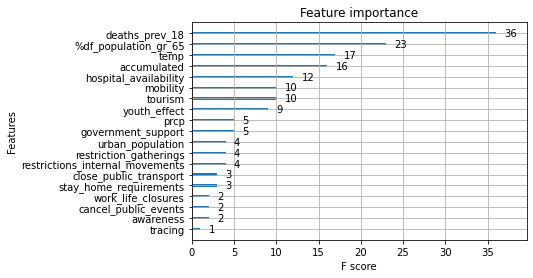

In [767]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams['figure.figsize'] = [20, 15]
plt.show()

## CatBoost annex for Feature Importance

In [768]:
ctbst = CatBoostRegressor(learning_rate=0.02, eval_metric='MAPE',depth=10, has_time=True)

ctbst.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)

0:	learn: 45.2954620	test: 35.6526956	best: 35.6526956 (0)	total: 46.3ms	remaining: 46.2s
1:	learn: 44.5954543	test: 35.3910068	best: 35.3910068 (1)	total: 95.3ms	remaining: 47.6s
2:	learn: 43.9525012	test: 35.3186838	best: 35.3186838 (2)	total: 132ms	remaining: 44s
3:	learn: 43.3134702	test: 35.0530431	best: 35.0530431 (3)	total: 163ms	remaining: 40.6s
4:	learn: 42.6458291	test: 34.6281643	best: 34.6281643 (4)	total: 192ms	remaining: 38.2s
5:	learn: 42.0127491	test: 34.1556697	best: 34.1556697 (5)	total: 222ms	remaining: 36.7s
6:	learn: 41.5647774	test: 33.8270159	best: 33.8270159 (6)	total: 255ms	remaining: 36.1s
7:	learn: 40.9932471	test: 33.4556695	best: 33.4556695 (7)	total: 297ms	remaining: 36.8s
8:	learn: 40.4115823	test: 33.0867074	best: 33.0867074 (8)	total: 333ms	remaining: 36.6s
9:	learn: 39.8001306	test: 32.7926678	best: 32.7926678 (9)	total: 362ms	remaining: 35.8s
10:	learn: 39.1835316	test: 32.5620817	best: 32.5620817 (10)	total: 391ms	remaining: 35.2s
11:	learn: 38.60252

In [769]:
y_pred = ctbst.predict(X_test)
y_pred_train = ctbst.predict(X_train)

In [770]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 988.2150245019975
mse score is 6274009.953061692
rmse score is 2504.79738762673
r2 score is 0.7222509014365743
mape score is inf


In [771]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 110.12179727920639
mse score is 27811.94026904673
rmse score is 166.7691226487887
r2 score is 0.9968721066192552
mape score is inf


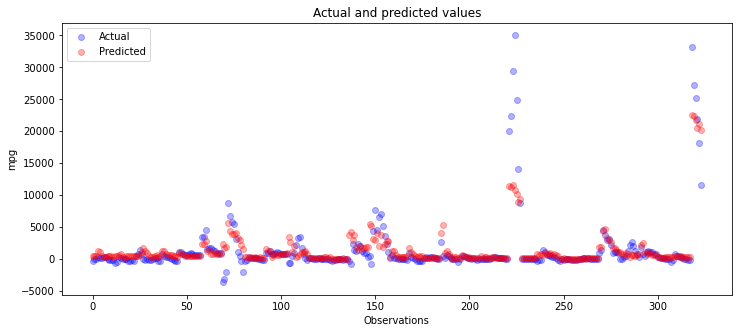

In [772]:
_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

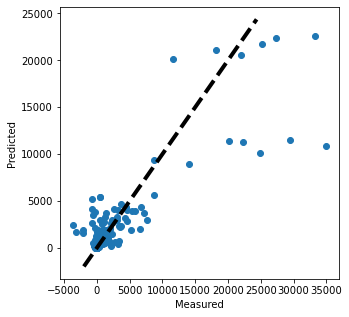

In [773]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

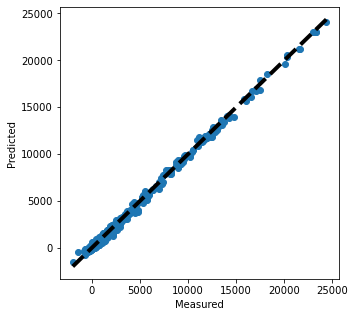

In [774]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Text(0.5, 0, 'CatBoost Feature Importance')

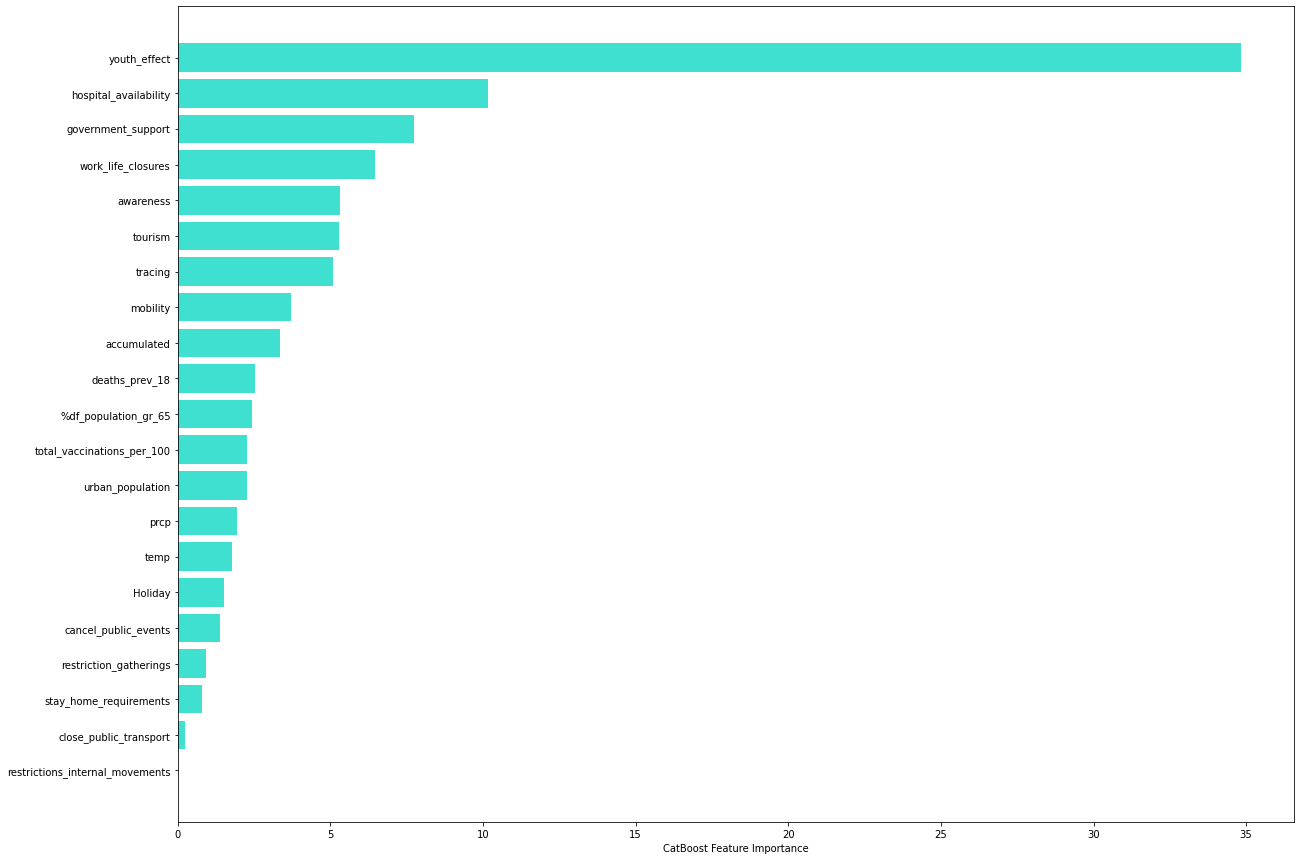

In [775]:
sorted_feature_importance = ctbst.feature_importances_.argsort()
plt.barh(df[df.columns[2:-1]].columns, 
        ctbst.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

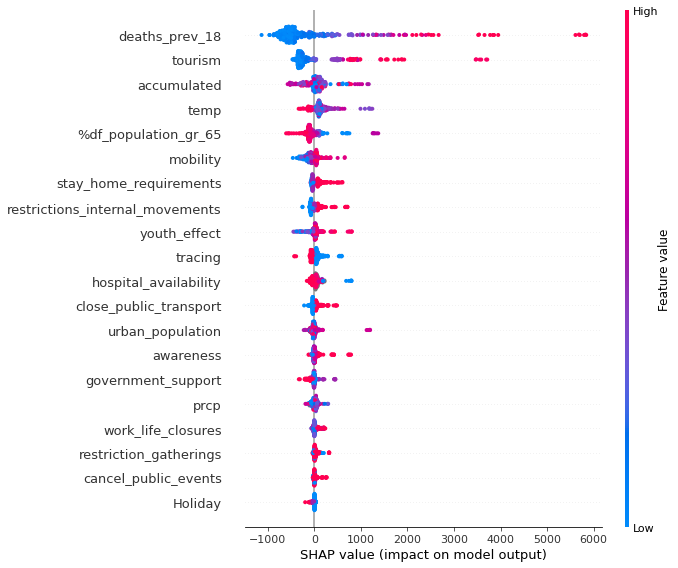

In [776]:
explainer = shap.TreeExplainer(ctbst)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = df[df.columns[2:-1]].columns)